RQ3: Do certain amenities have a more significant impact on success in specific geographic locations?
Compare three geographic locations in Italy: Florence, Venice, Bergamo

In [121]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from fuzzywuzzy import fuzz
import plotly.express as px

In [122]:
def load_data(file_path, city_name):
    df = pd.read_excel(file_path)
    df['city'] = city_name
    df = df.copy()  
    return df

def prepare_data_for_analysis(df):
    # filter the dataframe for listings with only 1 bed so the price is more comparable
    onebed_df = df[df['beds'] == 1][['host_location', 'beds', 'amenities', 'price', 'review_scores_rating']].copy()

    valid_df = onebed_df.dropna(subset=['price', 'review_scores_rating'])
    valid_df.loc[:, 'amenities'] = valid_df['amenities'].apply(lambda x: x.strip("[]").replace('"', '').split(", "))


    # one-hot encoding for amenities
    mlb = MultiLabelBinarizer()
    amenities_encoded = mlb.fit_transform(valid_df['amenities'])
    amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_, index=valid_df.index)
    prepared_df = valid_df.join(amenities_df)
    prepared_df.drop('amenities', axis=1, inplace=True)

    return prepared_df


In [123]:
florence_df = load_data(rf'listings_florence.xlsx', 'Florence')
venice_df = load_data(rf'listings_venice1.xlsx', 'Venice')
bergamo_df = load_data(rf'listings_bergamo.xlsx', 'Bergamo')

all_data = pd.concat([florence_df, venice_df, bergamo_df], ignore_index=True)


florence_prepared_df = prepare_data_for_analysis(florence_df)
#print(florence_prepared_df)
venice_prepared_df = prepare_data_for_analysis(venice_df)
bergamo_prepared_df = prepare_data_for_analysis(bergamo_df)

florence_prepared_df.head()

,host_location,beds,price,review_scores_rating,V\u00c4LBILDAD induction stove,. body soap,. refrigerator,.. refrigerator,14\ TV,14\ TV with standard cable,...,premium cable,radio,rooftop,saltwater,standard cable,stationary bike,treadmill,wardrobe,wood-burning,yoga mat
0,"Florence, Italy",1.0,158,4.66,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Florence, Italy",1.0,85,4.88,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Florence, Italy",1.0,70,4.84,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Florence, Italy",1.0,203,4.86,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Florence, Italy",1.0,175,4.85,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [124]:
# There are thousands of amenities, but many overlap, so we need to
# simplify them and group them together
amenities = [
    "Induction stove",
    "Electric stove",
    "Gas stove",
    "Oven",
    "Refrigerator",
    "Microwave",
    "Toaster",
    "Coffee maker",
    "Dishwasher",
    "Freezer",
    "TV",
    "HDTV",
    "DVD player",
    "Nintendo Wii",
    "Xbox",
    "PS",
    "Netflix",
    "Amazon Prime Video",
    "Disney+",
    "Hulu",
    "HBO Max",
    "Chromecast",
    "Fire TV",
    "Roku",
    "Sound system",
    "Record player",
    "Body soap",
    "Shampoo",
    "Conditioner",
    "Hair dryer",
    "Towels",
    "BBQ",
    "Outdoor kitchen",
    "Pool",
    "Hot tub",
    "Hammock",
    "Kayak",
    "Ping pong table",
    "Bikes",
    "Air conditioning",
    "Heating",
    "Washer",
    "Dryer",
    "Iron",
    "Treadmill",
    "Elliptical",
    "Free weights",
    "Yoga mat",
    "High chair",
    "Crib",
    "Baby monitor",
    "Changing Table",
    "Board games",
    "Books",
    "Wifi",
    "Ethernet",
    "Smart lock",
    "Security camera",
    "Alexa device",
    "Google device",
    "Apple TV",
    "HomePod",
    "EV charger",
    "Smoke alarm",
    "Carbon monoxide alarm",
    "Fire extinguisher",
    "First aid kit",
    "Bidet",
    "Sauna",
    "Gas fireplace",
    "Electric fireplace",
    "Wood-burning fireplace",
    "Piano",
    "City skyline view",
    "Canal view",
    "Mountain view",
    "River view",
    "Garden view",
    "Pool view",
    "Marina view",
    "Beach access",
    "Free parking",
    "Paid parking",
    "Parking on premises"
]

# Useful in future if we want to further simplify by category of amenities
buckets = {
    "Kitchen Appliances": amenities[0:10],
    "Entertainment": amenities[10:26],
    "Bathroom Essentials": amenities[26:31],
    "Outdoor/Recreational": amenities[31:39],
    "Comfort": amenities[39:41],
    "Laundry": amenities[41:44],
    "Fitness": amenities[44:48],
    "Kid Friendly": amenities[48:54],
    "Technology": amenities[54:63], 
    "Safety": amenities[63:67], 
    "Specialty Items": amenities[67:73], 
    "Views": amenities[73:81],
    "Parking": amenities[81:84], 
}

def simplify_amenities(df):
    new_df = df[['host_location', 'beds', 'price', 'review_scores_rating']]

    # Add columns for all the amenities
    new_df.loc[:,amenities] = 0

    # Iterate through amenities and place them in appropriate categoriesx
    for col in df.columns[4:]:
        max = 0
        max_amen = None

        for amen in amenities:
            # See if the string closely matches one of the predefined amenity categories
            partial_ratio = fuzz.partial_ratio(col.lower(), amen.lower())
            if partial_ratio > max:
                max = partial_ratio
                max_amen = amen

        # Found a match!
        if max_amen != None:
            # Only one-hot encode it if it isn't set yet (different col could map to same amen in our new_df)
            new_df.loc[new_df[max_amen] == 0, max_amen] = df[col]
                
    return new_df

florence_prepared_df = simplify_amenities(florence_prepared_df)
venice_prepared_df = simplify_amenities(venice_prepared_df)
bergamo_prepared_df  = simplify_amenities(bergamo_prepared_df)

florence_prepared_df.head()


,host_location,beds,price,review_scores_rating,Induction stove,Electric stove,Gas stove,Oven,Refrigerator,Microwave,...,Canal view,Mountain view,River view,Garden view,Pool view,Marina view,Beach access,Free parking,Paid parking,Parking on premises
0,"Florence, Italy",1.0,158,4.66,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1,"Florence, Italy",1.0,85,4.88,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Florence, Italy",1.0,70,4.84,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,"Florence, Italy",1.0,203,4.86,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8,"Florence, Italy",1.0,175,4.85,0,1,1,0,1,1,...,0,0,0,1,0,0,0,0,1,1


In [125]:
# Visualizing the range of prices across cities

print("Florence -----------------")
print(florence_prepared_df["price"].describe())
px.histogram(florence_prepared_df, x="price").show()

print("Venice -------------------")
print(venice_prepared_df["price"].describe())
px.histogram(venice_prepared_df, x="price").show()

print("Bergamo ------------------")
print(bergamo_prepared_df["price"].describe())
px.histogram(bergamo_prepared_df, x="price").show()

Florence -----------------
count     3738.000000
mean       172.441413
std       1346.828876
min         10.000000
25%         75.000000
50%        110.000000
75%        158.000000
max      80110.000000
Name: price, dtype: float64


Venice -------------------
count    2190.000000
mean      158.049315
std       221.751700
min        18.000000
25%        90.000000
50%       130.000000
75%       171.000000
max      5968.000000
Name: price, dtype: float64


Bergamo ------------------
count     736.000000
mean       97.616848
std       318.040138
min         9.000000
25%        57.000000
50%        75.000000
75%        96.000000
max      8500.000000
Name: price, dtype: float64


In [126]:
def analyze_and_visualize(city_df, city_name):
    correlation_matrix = city_df.drop(['host_location', 'beds'], axis=1).corr()
    price_correlation = correlation_matrix['price'].sort_values(ascending=False)
    review_score_correlation = correlation_matrix['review_scores_rating'].sort_values(ascending=False)
    
    top_price_amenities = price_correlation.head(6).index.drop('price')
    top_review_score_amenities = review_score_correlation.head(6).index.drop('review_scores_rating')
    top_amenities = set(top_price_amenities).union(set(top_review_score_amenities))
    top_correlation_matrix = city_df[list(top_amenities) + ['price', 'review_scores_rating']].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Heatmap of Amenities Correlation with Price in {city_name}')
    plt.show()
    
    # identify the top three amenities most correlated with price
    top_features = correlation_matrix['price'].sort_values(ascending=False).index[1:4] 
    #print(top_features)
    # bar charts for these top three amenities showing avg price with and without the amenities
    for feature in top_features:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=feature, y='price', data=city_df)
        plt.title(f'Listing with {feature} in {city_name}')
        plt.ylabel('Price')
        plt.xlabel(feature)
        plt.show()


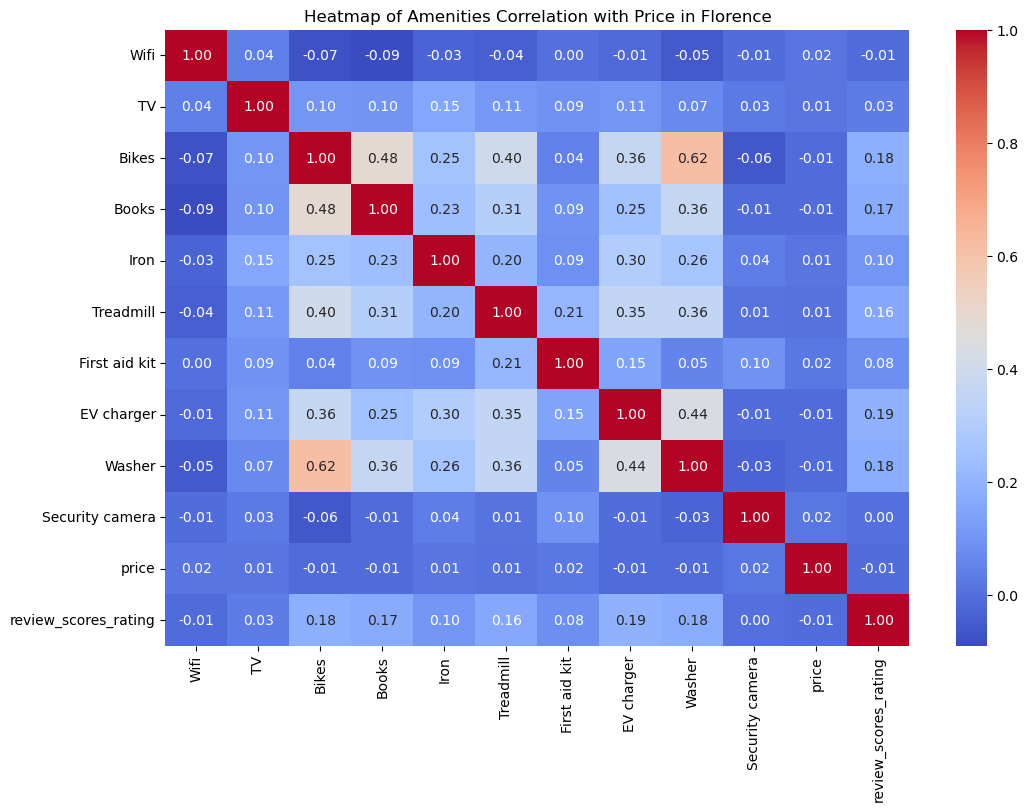

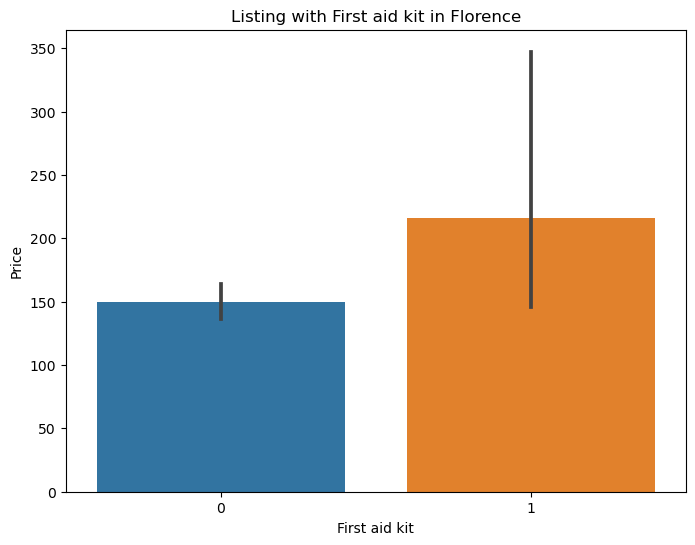

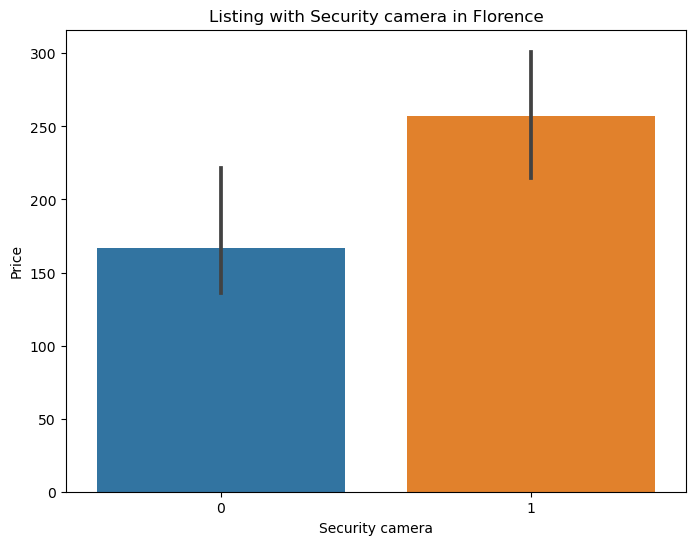

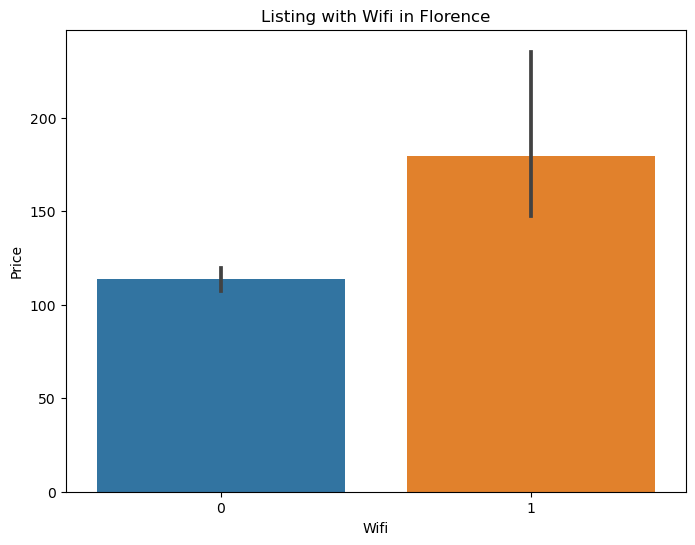

In [127]:
analyze_and_visualize(florence_prepared_df, "Florence")

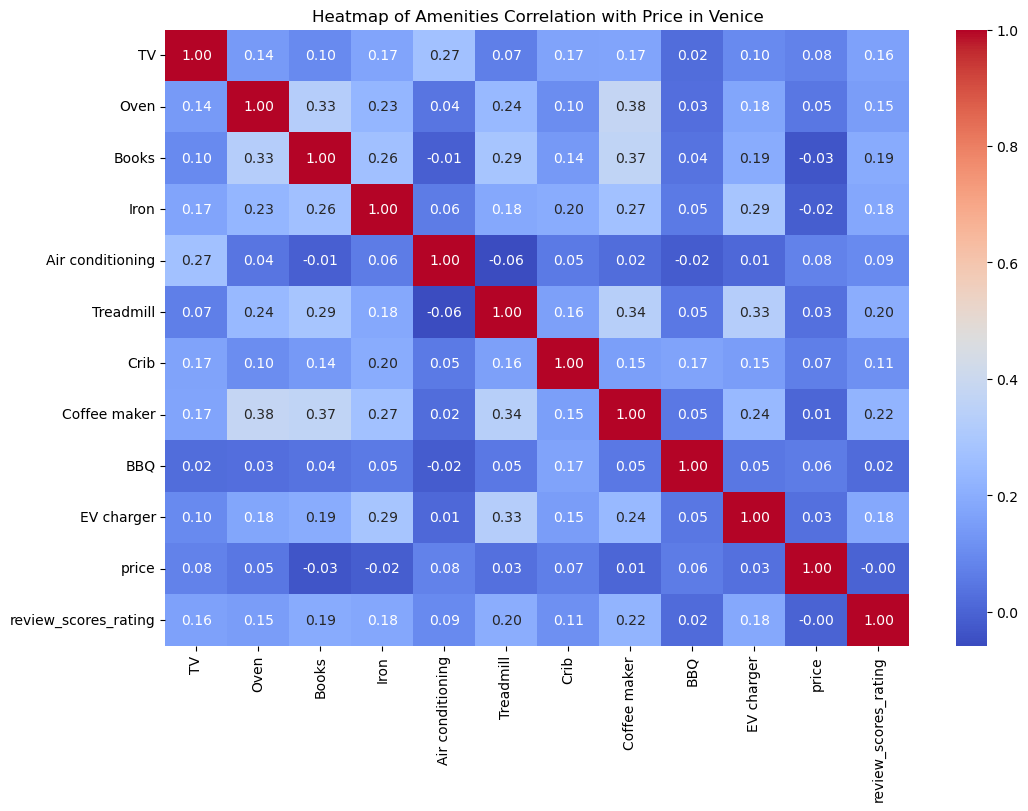

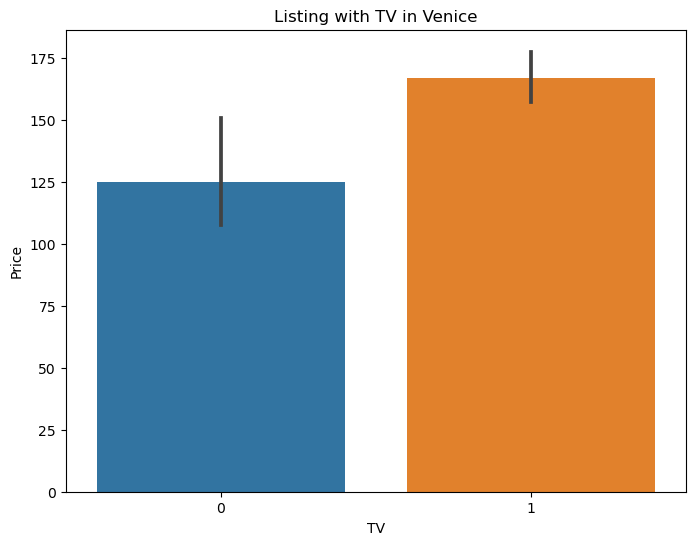

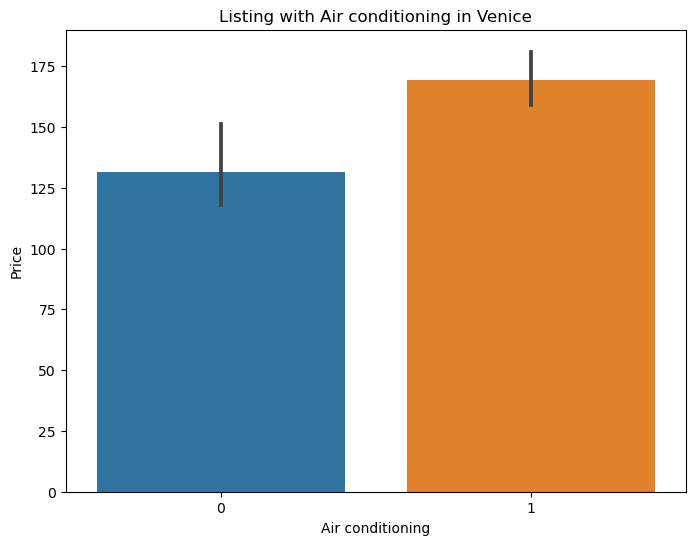

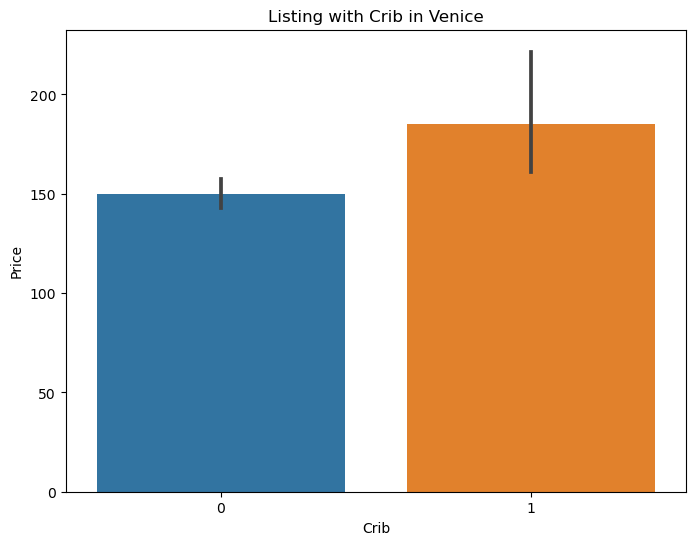

In [128]:
analyze_and_visualize(venice_prepared_df, 'Venice')

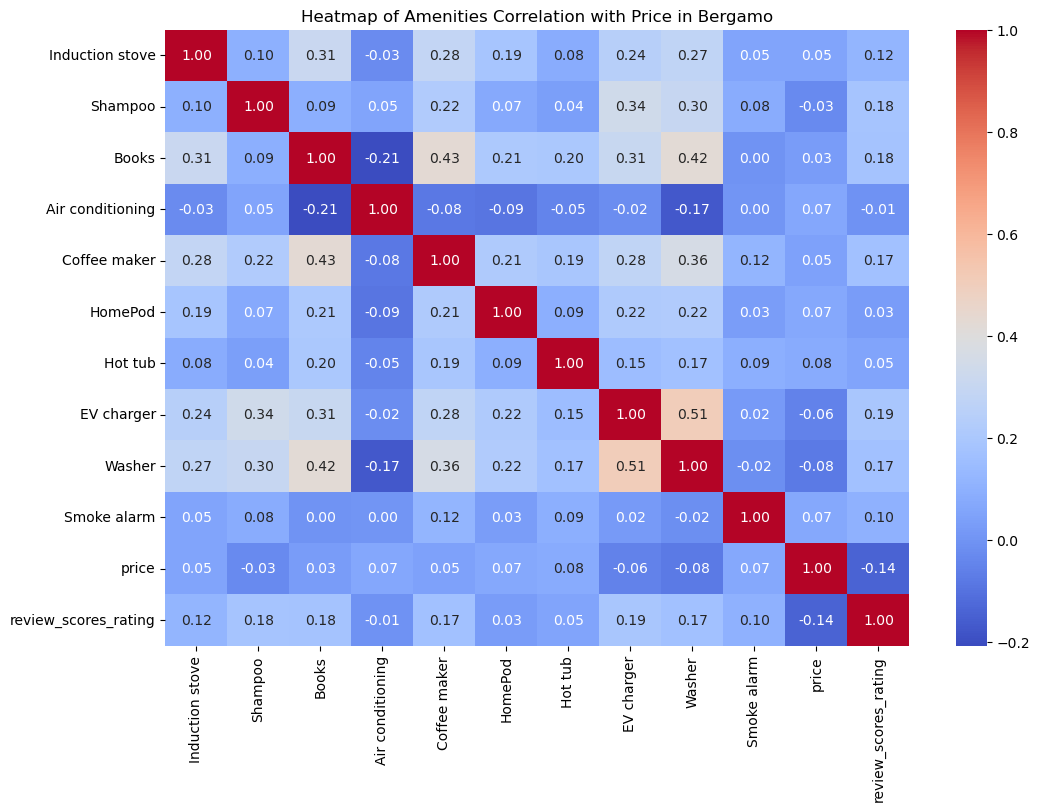

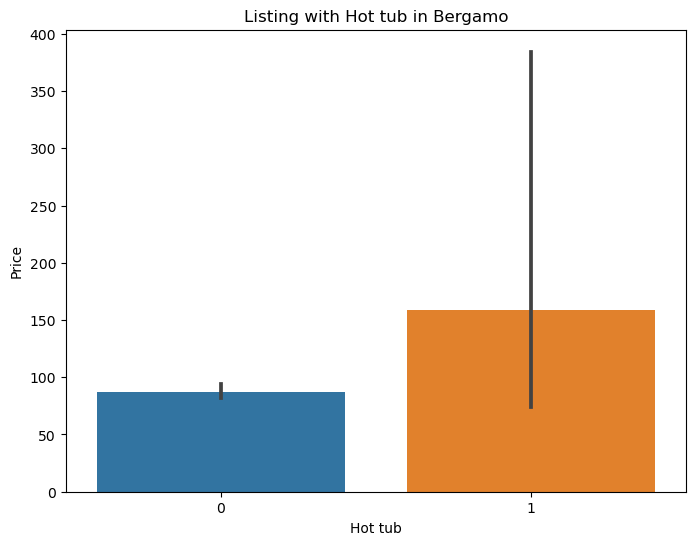

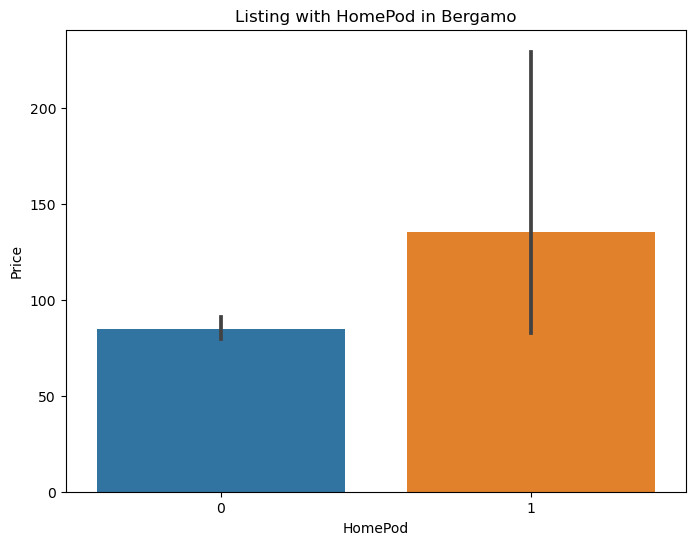

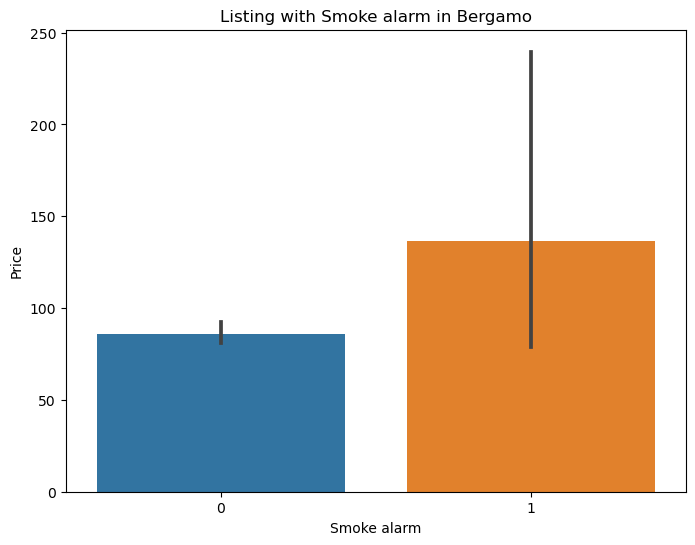

In [129]:
analyze_and_visualize(bergamo_prepared_df, 'Bergamo')